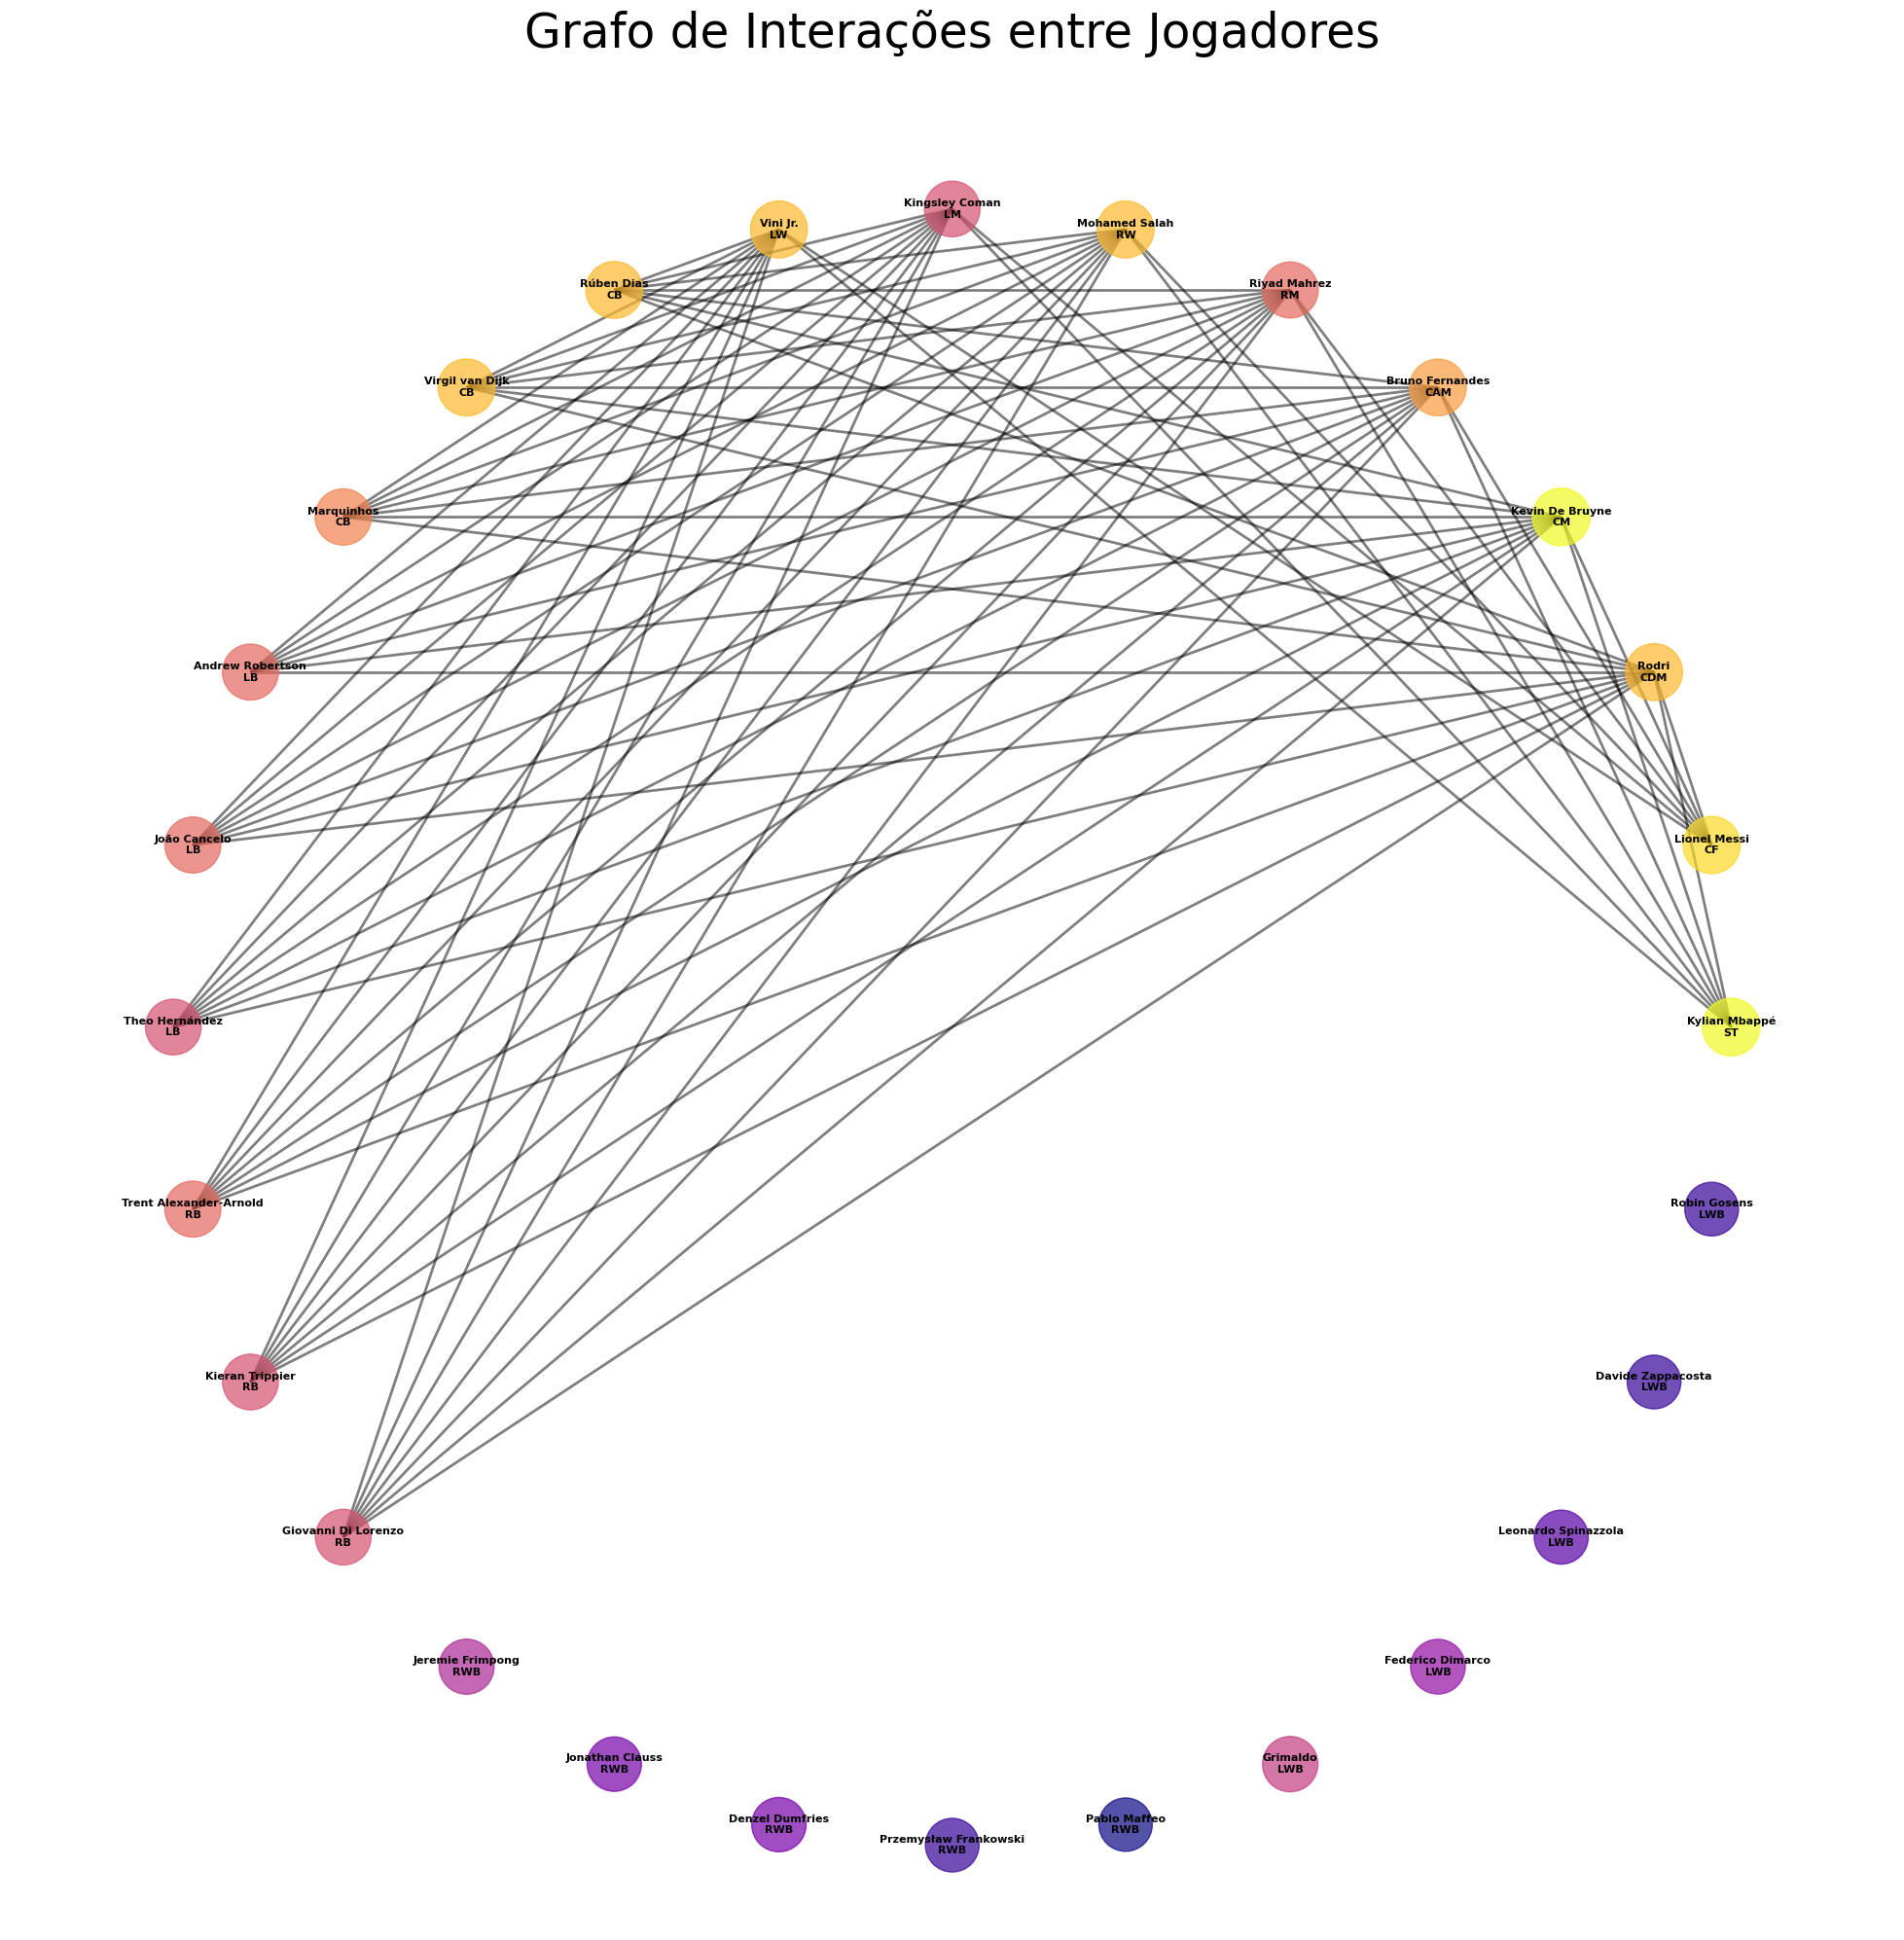

O grafo tem 77 arestas.


In [9]:
# Importando as bibliotecas necessárias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict


# Carregar o arquivo CSV filtrado em um DataFrame
filtered_csv_path = 'top_players_filtered.csv'
players_data = pd.read_csv(filtered_csv_path)

# Criar um grafo vazio
G = nx.Graph()

# Adicionar cada jogador como um nó no grafo
for index, row in players_data.iterrows():
    G.add_node(row['Name'], position=row['Position'], overall=row['Overall'])

# Categorias e seus respectivos thresholds
thresholds = {
    'Atacantes': 85,
    'Meias': 85,
    'Zagueiros': 85,
    'Laterais': 85
}

# Política de conexões baseada na lógica tática
# connection_policy = {
#     'Atacantes': ['Meias'],
#     'Meias': ['Atacantes', 'Zagueiros', 'Laterais'],
#     'Zagueiros': ['Meias', 'Laterais'],
#     'Laterais': ['Meias', 'Zagueiros']
# }
connection_policy = {
    'Atacantes': ['Meias'],
    'Meias': ['Laterais'],
    'Zagueiros': ['Meias'],
    'Laterais': ['Zagueiros']
}

# Mapeamento das posições específicas para suas categorias
position_to_category = {
    'ST': 'Atacantes', 'CF': 'Atacantes', 'RF': 'Atacantes', 'RS': 'Atacantes', 'LF': 'Atacantes', 'LS': 'Atacantes',
    'CDM': 'Meias', 'CM': 'Meias', 'CAM': 'Meias', 'ROM': 'Meias', 'RM': 'Meias', 'RWM': 'Meias', 'RW': 'Meias', 
    'LOM': 'Meias', 'LM': 'Meias', 'LWM': 'Meias', 'LW': 'Meias',
    'CB': 'Zagueiros', 'LB': 'Zagueiros', 'RB': 'Zagueiros',
    'RWB': 'Laterais', 'LWB': 'Laterais'
}

# Adicionando arestas com base na política de conexões e thresholds
for player1 in G.nodes():
    for player2 in G.nodes():
        if player1 != player2:
            player1_category = position_to_category[G.nodes[player1]['position']]
            player2_category = position_to_category[G.nodes[player2]['position']]
            if player2_category in connection_policy[player1_category]:
                if G.nodes[player1]['overall'] >= thresholds[player1_category] and G.nodes[player2]['overall'] >= thresholds[player2_category]:
                    G.add_edge(player1, player2)

# Configuração para a visualização do grafo
plt.figure(figsize=(25, 25))  # Aumentar o tamanho da figura para melhor visualização
pos = nx.circular_layout(G)  # Mudando para um layout circular para espaçar uniformemente os nós
# pos = nx.spring_layout(G)  # Mudando para um layout circular para espaçar uniformemente os nós

# Desenhando as arestas com uma largura visível e cor diferente
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='black')

# Desenhando os nós com um tamanho baseado no 'Overall', mas reduzido para evitar sobreposição
node_size = [G.nodes[node]['overall'] * 20 for node in G]  # Reduzindo o tamanho dos nós
node_color = [G.nodes[node]['overall'] for node in G]  # Cor dos nós baseado no 'Overall'
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, alpha=0.7)

# Desenhando os rótulos dentro dos nós
labels = {node: f"{node}\n{G.nodes[node]['position']}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold', verticalalignment='center')

plt.title("Grafo de Interações entre Jogadores", size=35)
plt.axis('off')  # Remove os eixos para uma visualização mais limpa
plt.show()

# Verifique se as arestas foram criadas
print(f"O grafo tem {G.number_of_edges()} arestas.")

/tmp/ipykernel_10820/3527275409.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(community_map.values()) + 1)


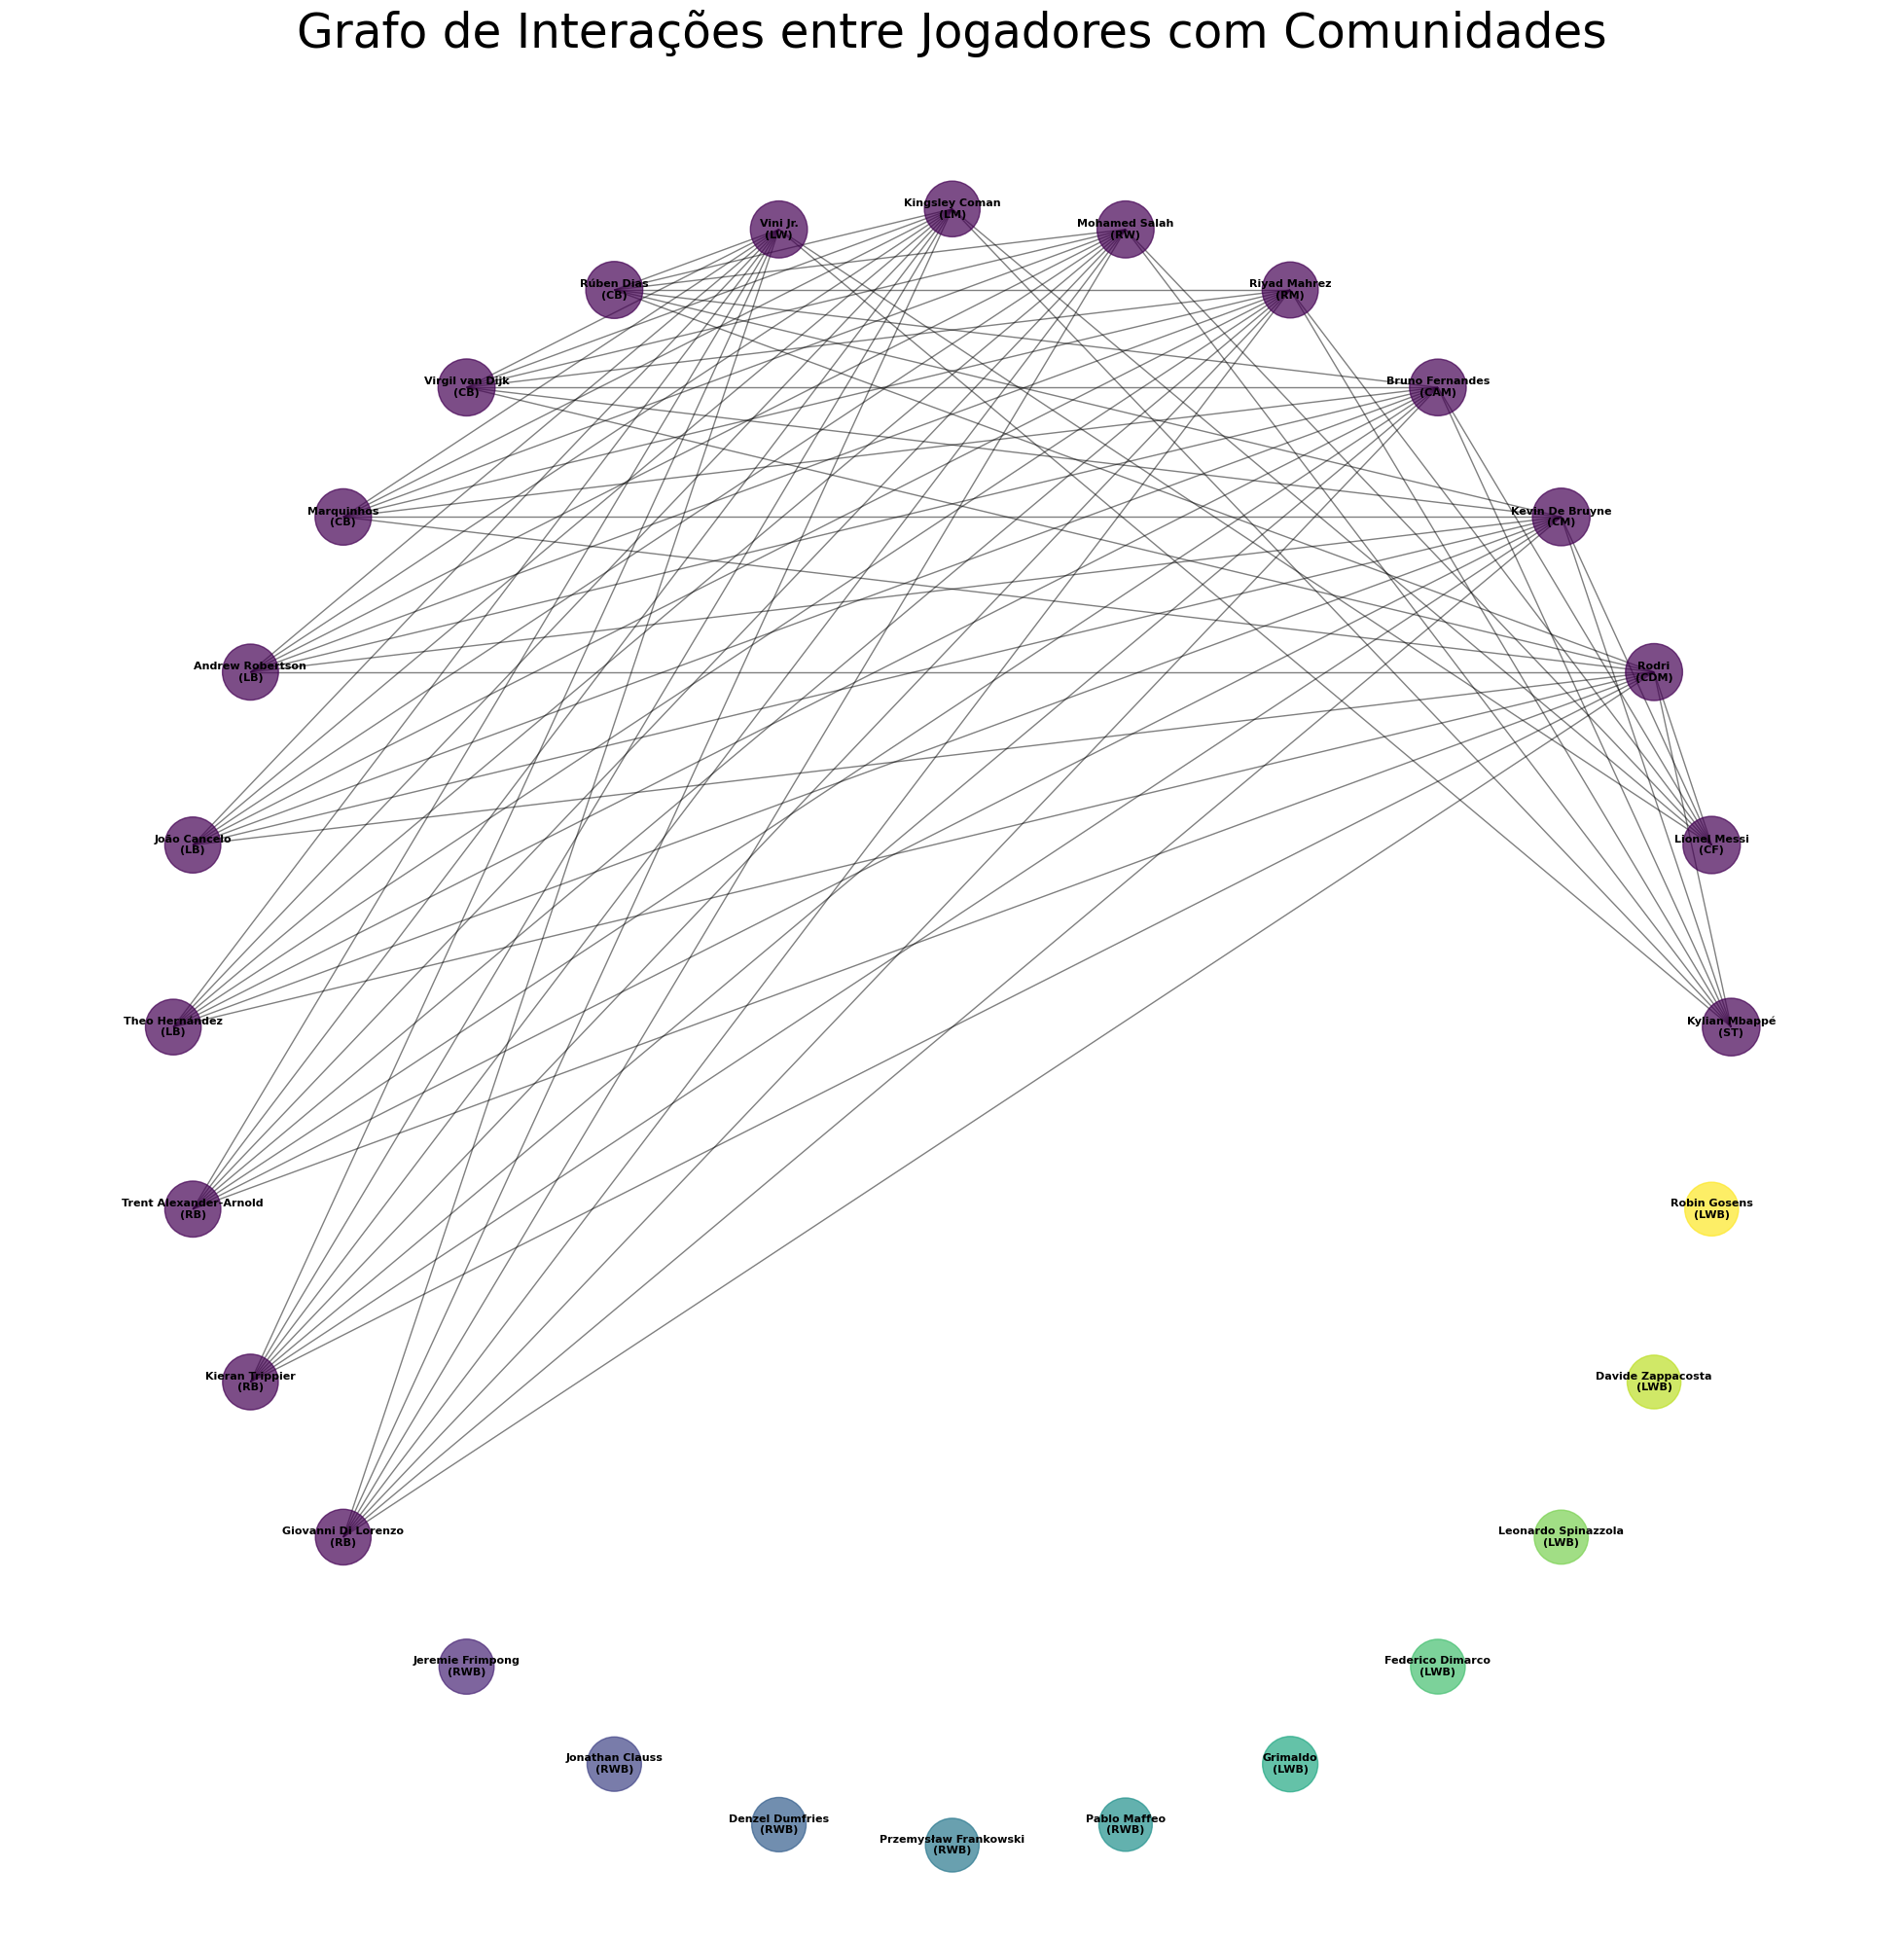

O maior cluster tem 18 jogadores.


In [10]:
# Continuando do código da Parte 1...

# Importando bibliotecas adicionais necessárias
from networkx.algorithms import community
import matplotlib.cm as cm

# Aplicando o algoritmo greedy_modularity_communities para detectar comunidades
communities = community.greedy_modularity_communities(G, weight='weight')

# Mapeando cada nó para a comunidade a que pertence
community_map = {}
for community_number, community_nodes in enumerate(communities):
    for node in community_nodes:
        community_map[node] = community_number

# Adicionando o número da comunidade como um atributo no grafo
nx.set_node_attributes(G, community_map, 'community')

# Identificando o cluster com o maior número de jogadores
largest_community = max(communities, key=len)
print(f"O maior cluster tem {len(largest_community)} jogadores.")

# Análise da composição do maior cluster em termos de posições dos jogadores
position_count = {}
for node in largest_community:
    position = G.nodes[node]['position']
    position_count[position] = position_count.get(position, 0) + 1
print("Composição do maior cluster por posição:", position_count)

# Visualização do grafo com as comunidades
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G)  # Usando spring_layout para melhor distribuição dos nós

# Desenhando os nós com cores de comunidade
cmap = cm.get_cmap('viridis', max(community_map.values()) + 1)
nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['overall'] * 20 for node in G.nodes()],
                       cmap=cmap, node_color=list(community_map.values()), alpha=0.7)

# Desenhando as arestas
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Desenhando os rótulos dos nós
labels = {node: f"{node}\n({G.nodes[node]['position']})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold', verticalalignment='center')

plt.title("Grafo de Interações entre Jogadores com Comunidades", size=35)
plt.axis('off')
plt.show()